### Investigate IP Overround

We know from previous data analysis that a large proportion of runners in-play decrease in price (~86%).

This notebook aims to investigate how 'inefficient' prices are inplay, by calculating the overround of inplay prices.

The overround is a measure of how much 'value' there is to be had in a bookmakers' prices.

A higher overround shows there is how bookmakers operate a profitable book. (Most books are often 105% to 110% for traditional bookmakers). Any book above 100% overround, that alys at the prices with the desired bet sizes can guarantee a profit no matter the result. Therefore this can also be a good indicator of the value that can be extracted from a market.

We also know that hedging can be very profitable with large swings in prices, and the overround can also be a solid indicator of this as we know BSP (Starting price - just prior to the race are very efficient).

---


__The original idea :__
To lay two horses below evens in a race as we know this has a high overround and happens more than often. 

__New idea:__
As opposed to backing 2+ horses below evens, why cap yourself to just horses going below evens. The market can still be exploited at all prices, and laying at all prices (providing a high overround book can still be achieved)

Expect this to be very low due to not all prices reaching their minimum's simultenosly

___

Below are a series of plots showing the distribution of the overrounds of markets for a recent sample of markets.

In [1]:
# 0: loading up data and packages

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd 
import pymysql
import numpy as np
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
connection = pymysql.connect(host='localhost', user='root', passwd ='xboxpass32', database = 'smartform')
cursor = connection.cursor()

In [82]:
query = ''' SELECT race_id, num_runners, handicap,  distance_yards, race_type, runner_id, historic_betfair_win_prices.win, historic_betfair_win_prices.total_traded, historic_betfair_win_prices.inplay_traded, historic_betfair_win_prices.bsp, historic_betfair_win_prices.inplay_min, historic_betfair_win_prices.inplay_max
            FROM historic_races
            JOIN historic_runners USING (race_id) JOIN historic_betfair_win_prices ON race_id=sf_race_id AND runner_id = sf_runner_id
            WHERE(CAST(historic_races.meeting_date AS Datetime) BETWEEN '2019-10-01' AND '2020-01-01')
            ORDER BY race_id, runner_id
        '''
cursor.execute(query)
rows = cursor.fetchall()

start = query.find('SELECT') + 7
end = query.find('\n            FROM', start)
names = query[start:end].split(', ')

df = pd.DataFrame(list(rows), columns=names)

print('No. Runners : ', df['runner_id'].nunique(), '\nNo.Races : ', df['race_id'].nunique())

30453

No. Runners :  14378 
No.Races :  2955


## 1st step : Calculating overround at BSP
(as a comparative measure to IP min)

In [83]:
df['bsp_prob'] = np.power(df['historic_betfair_win_prices.bsp'], -1)
df['or_bsp'] = round(df['bsp_prob'].groupby(df['race_id']).transform('sum').apply(float), 5)
df_races = df.groupby('race_id').first()
df_races.head()

,num_runners,handicap,distance_yards,race_type,runner_id,historic_betfair_win_prices.win,historic_betfair_win_prices.total_traded,historic_betfair_win_prices.inplay_traded,historic_betfair_win_prices.bsp,historic_betfair_win_prices.inplay_min,historic_betfair_win_prices.inplay_max,bsp_prob,or_bsp
race_id,,,,,,,,,,,,,
866014,28,0,1320,Flat,2436056,0,9180,149,37.17,30.00,1000.00,0.02690341673392520850147968792,1.00527
881005,17,0,1320,Flat,2445152,0,23956,1141,15.47,12.00,1000.00,0.06464124111182934712346477052,1.00903
897700,9,0,1760,Flat,2283995,1,17359,75050,30.00,1.01,250.00,0.03333333333333333333333333333,1.00440
897701,9,0,3520,Flat,1854563,0,10961,1280,98.11,48.00,1000.00,0.01019264091326062582815207420,1.00533
897702,17,0,1320,Flat,2025460,0,55866,1482,14.24,10.00,1000.00,0.07022471910112359550561797753,0.97051


<Figure size 1008x432 with 0 Axes>

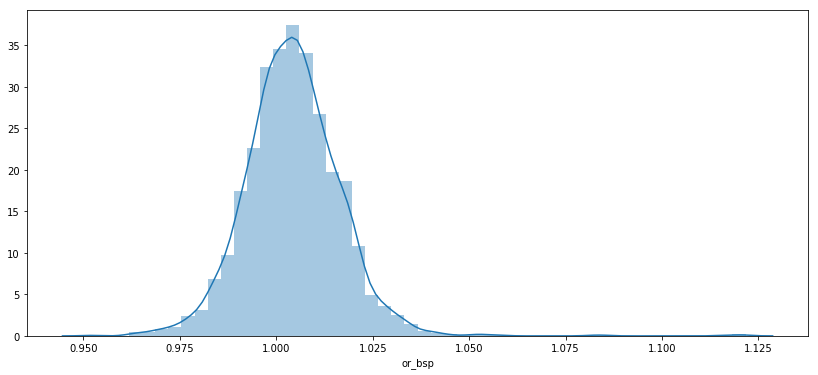

In [84]:
# Plotting distribution of overround at bsp's
plt.figure(figsize=(14,6))
sns.distplot(df_races['or_bsp'])

In [85]:
# Counts of overround bsps (below/above 100%)
print('Median : ', df_races['or_bsp'].median(),
      '\nNo. Below 1.00 : ', df_races.loc[df_races['or_bsp'] < 1.0].shape[0],
      '\nNo. Above 1.00 : ', df_races.loc[df_races['or_bsp'] >= 1.0].shape[0],)

Median :  1.00402 
No. Below 1.00 :  1065 
No. Above 1.00 :  1890


This shows that the majority of markets have an overround very close to one, meaning that is very difficult for a backer and layer acting in these markets to make money just backing / laying all prices.

## 2nd Step : Calculating overround at IP min

In [86]:
df['ipmin_prob'] = np.power(df['historic_betfair_win_prices.inplay_min'], -1)
df['or_ipmin'] = round(df['ipmin_prob'].groupby(df['race_id']).transform('sum').apply(float), 5)
df_races = df.groupby('race_id').first()
df_races.head()

,num_runners,handicap,distance_yards,race_type,runner_id,historic_betfair_win_prices.win,historic_betfair_win_prices.total_traded,historic_betfair_win_prices.inplay_traded,historic_betfair_win_prices.bsp,historic_betfair_win_prices.inplay_min,historic_betfair_win_prices.inplay_max,bsp_prob,or_bsp,ipmin_prob,or_ipmin
race_id,,,,,,,,,,,,,,,
866014,28,0,1320,Flat,2436056,0,9180,149,37.17,30.00,1000.00,0.02690341673392520850147968792,1.00527,0.03333333333333333333333333333,2.35666
881005,17,0,1320,Flat,2445152,0,23956,1141,15.47,12.00,1000.00,0.06464124111182934712346477052,1.00903,0.08333333333333333333333333333,2.21056
897700,9,0,1760,Flat,2283995,1,17359,75050,30.00,1.01,250.00,0.03333333333333333333333333333,1.00440,0.9900990099009900990099009901,3.54722
897701,9,0,3520,Flat,1854563,0,10961,1280,98.11,48.00,1000.00,0.01019264091326062582815207420,1.00533,0.02083333333333333333333333333,2.43916
897702,17,0,1320,Flat,2025460,0,55866,1482,14.24,10.00,1000.00,0.07022471910112359550561797753,0.97051,0.1,4.37360


<Figure size 1008x432 with 0 Axes>

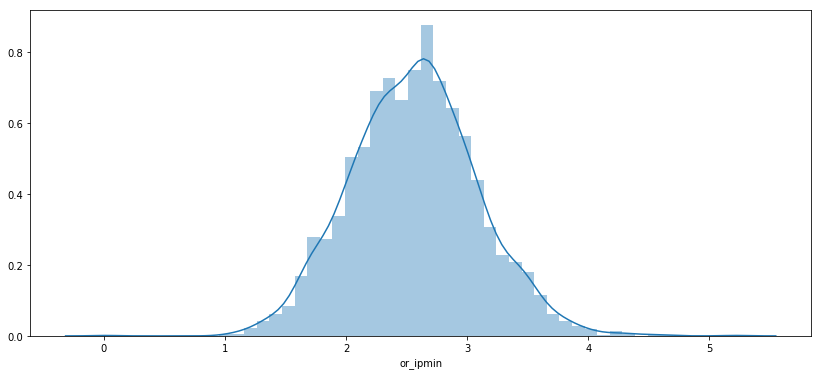

In [87]:
# Plotting distribution of overround at ip_min's
plt.figure(figsize=(14,6))
sns.distplot(df_races['or_ipmin'])

In [88]:
# Counts of overround bsps (below/above 100%)
print('Median : ', df_races['or_ipmin'].median(),
      '\nNo. Below 1.00 : ', df_races.loc[df_races['or_ipmin'] < 1.0].shape[0],
      '\nNo. Above 1.00 : ', df_races.loc[df_races['or_ipmin'] >= 1.0].shape[0],)

Median :  2.56847 
No. Below 1.00 :  1 
No. Above 1.00 :  2954


This shows a much higher level of overround in inplay markets - lots of potential to lay a profitable book and a good indicator for profitable hedge bets to be made

## 2.5 Step : Calculating overround at IP min (without winners)

In [100]:
dfx = df
df_temp = dfx.loc[dfx['historic_betfair_win_prices.win'] ==0].copy()

In [101]:
df_temp['ipmin_prob'] = np.power(df_temp['historic_betfair_win_prices.inplay_min'], -1)
df_temp['or_ipmin'] = round(df_temp['ipmin_prob'].groupby(df_temp['race_id']).transform('sum').apply(float), 5)
df_races = df_temp.groupby('race_id').first()
df_races.head()

,num_runners,handicap,distance_yards,race_type,runner_id,historic_betfair_win_prices.win,historic_betfair_win_prices.total_traded,historic_betfair_win_prices.inplay_traded,historic_betfair_win_prices.bsp,historic_betfair_win_prices.inplay_min,historic_betfair_win_prices.inplay_max,bsp_prob,or_bsp,ipmin_prob,or_ipmin,ipmax_prob,or_ipmax
race_id,,,,,,,,,,,,,,,,,
866014,28,0,1320,Flat,2436056,0,9180,149,37.17,30.00,1000.00,0.02690341673392520850147968792,1.00527,0.03333333333333333333333333333,1.36656,0.001,0.36278
881005,17,0,1320,Flat,2445152,0,23956,1141,15.47,12.00,1000.00,0.06464124111182934712346477052,1.00903,0.08333333333333333333333333333,1.22047,0.001,0.22495
897700,9,0,1760,Flat,2300479,0,333467,33303,3.84,2.00,1000.00,0.2604166666666666666666666667,1.00440,0.5,2.55712,0.001,0.01200
897701,9,0,3520,Flat,1854563,0,10961,1280,98.11,48.00,1000.00,0.01019264091326062582815207420,1.00533,0.02083333333333333333333333333,1.46829,0.001,0.06364
897702,17,0,1320,Flat,2025460,0,55866,1482,14.24,10.00,1000.00,0.07022471910112359550561797753,0.97051,0.1,3.38350,0.001,0.01874


<Figure size 1008x432 with 0 Axes>

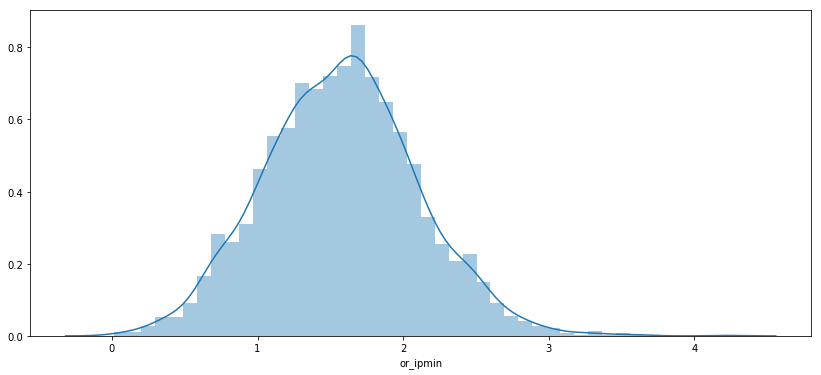

In [102]:
# Plotting distribution of overround at ip_min's
plt.figure(figsize=(14,6))
sns.distplot(df_races['or_ipmin'])

In [92]:
# Counts of overround bsps (below/above 100%)
print('Median : ', df_races['or_ipmin'].median(),
      '\nNo. Below 1.00 : ', df_races.loc[df_races['or_ipmin'] < 1.0].shape[0],
      '\nNo. Above 1.00 : ', df_races.loc[df_races['or_ipmin'] >= 1.0].shape[0],)

Median :  1.58034 
No. Below 1.00 :  395 
No. Above 1.00 :  2560


Backing even just the horses don't win show a very promising market to make money from. 

### 3rd Step : Calculating overround at IP max

In [93]:
df['ipmax_prob'] = np.power(df['historic_betfair_win_prices.inplay_max'], -1)
df['or_ipmax'] = round(df['ipmax_prob'].groupby(df['race_id']).transform('sum').apply(float), 5)
df_races = df.groupby('race_id').first()
df_races.head()

,num_runners,handicap,distance_yards,race_type,runner_id,historic_betfair_win_prices.win,historic_betfair_win_prices.total_traded,historic_betfair_win_prices.inplay_traded,historic_betfair_win_prices.bsp,historic_betfair_win_prices.inplay_min,historic_betfair_win_prices.inplay_max,bsp_prob,or_bsp,ipmin_prob,or_ipmin,ipmax_prob,or_ipmax
race_id,,,,,,,,,,,,,,,,,
866014,28,0,1320,Flat,2436056,0,9180,149,37.17,30.00,1000.00,0.02690341673392520850147968792,1.00527,0.03333333333333333333333333333,2.35666,0.001,0.36278
881005,17,0,1320,Flat,2445152,0,23956,1141,15.47,12.00,1000.00,0.06464124111182934712346477052,1.00903,0.08333333333333333333333333333,2.21056,0.001,0.22495
897700,9,0,1760,Flat,2283995,1,17359,75050,30.00,1.01,250.00,0.03333333333333333333333333333,1.00440,0.9900990099009900990099009901,3.54722,0.004,0.01200
897701,9,0,3520,Flat,1854563,0,10961,1280,98.11,48.00,1000.00,0.01019264091326062582815207420,1.00533,0.02083333333333333333333333333,2.43916,0.001,0.06364
897702,17,0,1320,Flat,2025460,0,55866,1482,14.24,10.00,1000.00,0.07022471910112359550561797753,0.97051,0.1,4.37360,0.001,0.01874


<Figure size 1008x432 with 0 Axes>

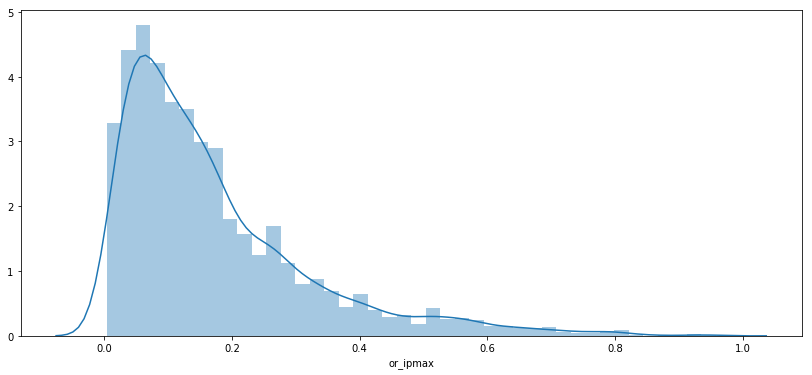

In [94]:
# Plotting distribution of overround at ip_max's
plt.figure(figsize=(14,6))
sns.distplot(df_races.loc[df_races['or_ipmax'] < 1.0]['or_ipmax']) # removing outliers

In [95]:
# Counts of overround bsps (below/above 100%)
print('Median : ', df_races['or_ipmax'].median(),
      '\nNo. Below 1.00 : ', df_races.loc[df_races['or_ipmax'] < 1.0].shape[0],
      '\nNo. Above 1.00 : ', df_races.loc[df_races['or_ipmax'] >= 1.0].shape[0],)

Median :  0.13002 
No. Below 1.00 :  2923 
No. Above 1.00 :  32
